In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pandas as pd
import seaborn as sns

In [26]:
train_set = pd.read_csv('data/Price_euros_train.csv')
test_set = pd.read_csv('data/Price_euros_test.csv')
sub_set = pd.read_csv('data/Sample_submition.csv')

In [3]:
print(train_set.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1108 non-null   int64  
 1   Company           1108 non-null   object 
 2   Product           1108 non-null   object 
 3   TypeName          1108 non-null   object 
 4   Inches            1108 non-null   float64
 5   ScreenResolution  1097 non-null   object 
 6   Cpu               1108 non-null   object 
 7   Ram               1108 non-null   object 
 8   Memory            1108 non-null   object 
 9   Gpu               1108 non-null   object 
 10  OpSys             1055 non-null   object 
 11  Weight            1086 non-null   object 
 12  Price_euros       1108 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 112.7+ KB
None


In [4]:
print(test_set.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         195 non-null    int64  
 1   Company           195 non-null    object 
 2   Product           195 non-null    object 
 3   TypeName          195 non-null    object 
 4   Inches            195 non-null    float64
 5   ScreenResolution  193 non-null    object 
 6   Cpu               195 non-null    object 
 7   Ram               195 non-null    object 
 8   Memory            195 non-null    object 
 9   Gpu               195 non-null    object 
 10  OpSys             183 non-null    object 
 11  Weight            191 non-null    object 
dtypes: float64(1), int64(1), object(10)
memory usage: 18.4+ KB
None


In [5]:
def top_columns_with_nulls(dataframe, top_n=5):
    total_rows = len(dataframe)
    null_counts = dataframe.isnull().sum()
    null_percentage = (null_counts / total_rows) * 100
    null_info_df = pd.DataFrame({
        'Column': null_counts.index,
        'Null Count': null_counts.values,
        'Null Percentage': null_percentage.values
    })
    sorted_nulls = null_info_df.sort_values(by='Null Count', ascending=False)
    return sorted_nulls.head(top_n)

print(top_columns_with_nulls(test_set))
print()
print(top_columns_with_nulls(train_set))

              Column  Null Count  Null Percentage
10             OpSys          12         6.153846
11            Weight           4         2.051282
5   ScreenResolution           2         1.025641
0          laptop_ID           0         0.000000
3           TypeName           0         0.000000

              Column  Null Count  Null Percentage
10             OpSys          53         4.783394
11            Weight          22         1.985560
5   ScreenResolution          11         0.992780
1            Company           0         0.000000
0          laptop_ID           0         0.000000


In [6]:
def kg_to_float(dataframe, column_name):
    converted_df = dataframe.copy()
    converted_df[column_name] = (
        converted_df[column_name]
        .str.replace('kg', '', regex=False)  # Remove 'kg'
        .str.strip()                        # Remove leading/trailing spaces
        .astype(float)                      # Convert to float
    )
    print(f"Column '{column_name}' converted to float.")
    return converted_df
def delete_null_rows(dataframe):
    cleaned_df = dataframe.dropna()
    print(f"Rows removed: {len(dataframe) - len(cleaned_df)}")
    return cleaned_df
def auto_fill_nulls(dataframe):
    filled_df = dataframe.copy()
    for column in filled_df.columns:
        if filled_df[column].isnull().sum() > 0:  # Only process columns with nulls
            if np.issubdtype(filled_df[column].dtype, np.number):
                # Fill numeric column with median
                median_value = filled_df[column].median()
                filled_df[column].fillna(median_value, inplace=True)
                print(f"Filled nulls in numeric column '{column}' with median value: {median_value}")
            else:
                # Fill non-numeric column with random choice from top 3 most common values
                top_3_values = filled_df[column].value_counts().index[:3]
                if len(top_3_values) > 0:  # Ensure there are enough values to choose from
                    random_choice = np.random.choice(top_3_values)
                    filled_df[column].fillna(random_choice, inplace=True)
                    print(f"Filled nulls in non-numeric column '{column}' with random choice from top 3: {random_choice}")
                else:
                    print(f"Column '{column}' has no valid non-null values to use for filling.")
    return filled_df

In [7]:
test_set = kg_to_float(test_set, column_name="Weight")
train_set = kg_to_float(train_set, column_name="Weight")
filled_test = auto_fill_nulls(test_set)
dropped_test = delete_null_rows(test_set)
filled_train =  auto_fill_nulls(train_set)
dropped_train = delete_null_rows(train_set)


Column 'Weight' converted to float.
Column 'Weight' converted to float.
Filled nulls in non-numeric column 'ScreenResolution' with random choice from top 3: Full HD 1920x1080
Filled nulls in non-numeric column 'OpSys' with random choice from top 3: Windows 7
Filled nulls in numeric column 'Weight' with median value: 2.04
Rows removed: 18
Filled nulls in non-numeric column 'ScreenResolution' with random choice from top 3: IPS Panel Full HD 1920x1080
Filled nulls in non-numeric column 'OpSys' with random choice from top 3: No OS
Filled nulls in numeric column 'Weight' with median value: 2.04
Rows removed: 82


C:\Users\1TB\AppData\Local\Temp\ipykernel_14144\473903393.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filled_df[column].fillna(random_choice, inplace=True)
C:\Users\1TB\AppData\Local\Temp\ipykernel_14144\473903393.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

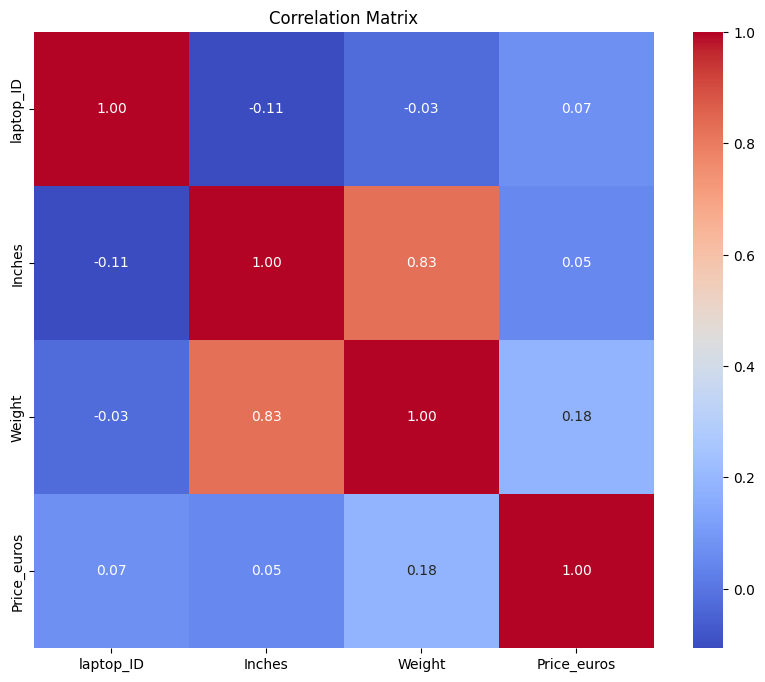

In [8]:

numerical_cols = filled_train.select_dtypes(include=['number'])
correlation_matrix = numerical_cols.corr()
# Plot a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [16]:
from sklearn.model_selection import train_test_split

def split_train_test(dataframe, target_column, test_size=0.2, random_state=42):
    X = dataframe.drop(columns=[target_column])
    print(X)
    y = dataframe[target_column]    
    print(y)
    assert len(X) == len(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    print(f"Data split complete: {len(X_train)} training rows, {len(X_test)} test rows.")
    return X_train, X_test, y_train, y_test

big_drop_df = filled_train.drop(columns=['OpSys', 'Company', 'Product', 'TypeName',
                                         'ScreenResolution', 'Cpu', 'Gpu', 'Ram', 'Memory'])

x_train, x_test, y_train, y_test = split_train_test(big_drop_df, 'Price_euros')

      laptop_ID  Inches  Weight
0             2    13.3    1.34
1             4    15.4    1.83
2             5    13.3    1.37
3             6    15.6    2.10
4             7    15.4    2.04
...         ...     ...     ...
1103       1315    15.6    2.20
1104       1316    14.0    1.80
1105       1318    14.0    1.50
1106       1319    15.6    2.19
1107       1320    15.6    2.20

[1108 rows x 3 columns]
0        898.94
1       2537.45
2       1803.60
3        400.00
4       2139.97
         ...   
1103     720.32
1104     638.00
1105     229.00
1106     764.00
1107     369.00
Name: Price_euros, Length: 1108, dtype: float64
Data split complete: 886 training rows, 222 test rows.


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [25]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R^2 Score: {r2}")
y_pred

RMSE: 554.4021318651198
R^2 Score: 0.3729517362472773


array([1019.8556, 1851.84  ,  794.1459, 1181.95  , 2615.5509,  812.291 ,
       1390.043 , 1116.66  , 1580.318 , 2369.809 ,  576.7092,  794.5815,
        701.4019,  761.3775,  953.0272,  553.0356,  850.4893, 1587.35  ,
        840.3374, 1193.8604,  565.8379, 1175.1099,  908.84  , 1446.57  ,
        712.9032, 1458.7276,  648.7845,  539.3984, 1516.0904, 1446.7386,
       3358.1658,  845.71  ,  953.62  , 2340.8497,  778.6029,  818.0871,
       1416.9975,  549.181 , 1521.7254, 1639.4239, 1352.2247,  993.26  ,
        919.    , 2884.9666, 1576.7028,  680.6244, 2458.4674, 1355.739 ,
        629.5805, 1211.778 ,  351.14  , 1644.1949, 1197.6173,  632.5444,
       2008.4388,  617.3347,  724.6663,  893.3027,  841.3232,  948.4739,
       1353.4359, 1173.0583, 1162.1996,  736.0736, 1824.133 , 1164.7627,
        506.05  ,  973.5137,  928.591 , 1238.5207,  886.9783,  417.0809,
        471.1218, 1296.667 ,  906.4501, 1082.1097, 1015.828 , 1161.4   ,
       1860.832 , 2846.4392,  535.0748, 1473.1879, 

In [ ]:
print(sub_set.head())
print(f"Number of entries in sample submission: {len(sub_set)}")
print(test_set.head())
print(f"Number of entries in test data: {len(test_set)}")

test_ids = set(test_set['laptop_ID'])
sample_ids = set(sub_set['index'])

# Check for missing or extra IDs
missing_in_test = sample_ids - test_ids
extra_in_test = test_ids - sample_ids

test_data_filtered = test_set[test_set['laptop_ID'].isin(sub_set['index'])]

X_test = test_data_filtered.drop(columns=['OpSys', 'Company', 'Product', 'TypeName',
                                         'ScreenResolution', 'Cpu', 'Gpu', 'Ram', 'Memory'])
X_test = kg_to_float(X_test, column_name="Weight")
predictions = model.predict(X_test)

submission = pd.DataFrame({
    'index': test_data_filtered['laptop_ID'],
    'Price_euros': predictions
})

# Merge with sample_submission to ensure correct order
submission = sub_set[['index']].merge(submission, on='Id', how='left')

# Check for any missing predictions
if submission['Price_euros'].isnull().any():
    print("Warning: Some IDs have missing predictions.")
    # Handle missing predictions as needed

# Save the submission file
submission.to_csv('submission.csv', index=False)

   index  Price_euros
0      0          1.1
1      1          1.1
2      2          1.1
3      3          1.1
4      4          1.1
Number of entries in sample submission: 195
   laptop_ID Company           Product  TypeName  Inches   ScreenResolution  \
0         86    Acer          Aspire 3  Notebook    15.6           1366x768   
1       1249   Razer         Blade Pro    Gaming    14.0  Full HD 1920x1080   
2        122    Asus      VivoBook S15  Notebook    15.6  Full HD 1920x1080   
3        993    Asus  Rog GL753VE-DS74    Gaming    17.3  Full HD 1920x1080   
4        739    Dell     Inspiron 3567  Notebook    15.6           1366x768   

                           Cpu   Ram                Memory  \
0      AMD A9-Series 9420 3GHz   4GB               1TB HDD   
1  Intel Core i7 7700HQ 2.8GHz  16GB               1TB SSD   
2   Intel Core i7 8550U 1.8GHz   8GB             256GB SSD   
3  Intel Core i7 7700HQ 2.8GHz  16GB  256GB SSD +  1TB HDD   
4   Intel Core i5 7200U 2.5GHz  12GB   